## EV Block
This class defines variables and parameters for Electric Vehicles (EVs), whereas specific characteristic of each EV is defined by dictionary data on data file (data.py).
    
Battery limitations, degradation costs as well as variables calculation for optimization are all described by Constraints.

In [2]:
from pyomo.environ import *
#from PL import C
#from data import *

#m.time    = Set(initialize=(0,288))
#m.ev      = Set(initialize=(0,5))

class EV:
           
    def __init__(self, *args, **kwds):
        
        self.Bcap   = Param(self.ev, default=Bcap,  doc='Battery capacity',             mutable=True)
        self.Pmax   = Param(self.ev, default=Pmax,  doc='Maximum charging power',       mutalbe=True)
        self.SoCi   = Param(self.ev, default=SoCi,  doc='Initial State of Charge (SoC)',mutable=True)
        self.SoCf   = Param(self.ev, default=SoCf,  doc='Final State of Charge (SoC)',  mutable=True)
        self.arr    = Param(self.ev, default=arr,   doc='Arrival time',                 mutable=True)
        self.dep    = Param(self.ev, default=dep,   doc='Departure time',               mutable=True)
        self.ef     = Param(default=ef,             doc='Charging efficiency',          mutable=True)
        self.Ts     = Param(default=Ts,             doc='Time sample',                  mutable=True)
            
        self.a      = Var(self.ev, self.time,       doc='Connection status',            initialize=0, within=Binary)      
        self.SoC    = Var(self.ev, self.time,       doc='SoC at each time step',        initialize=0)           
        self.Cdeg   = Var(self.ev, self.time,       doc='Degradation cost',             initialize=0)              
        self.roC    = Var(self.ev, self.time,       doc='Charging priority index',      initialize=0)                  
        self.yC     = Var(self.ev, self.time,       doc='Degradation cost index',       initialize=0)                 
#       self.C      = Var(self.ev, self.time,       doc='Charging rate',                initialize=0) # From objective function! C is my decision variable.


### 1. Variables calculation:
#### 1.1 Maximum Degradation Cost Calculation:
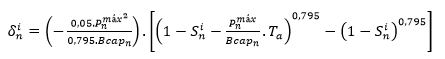
Is well known from the equation above that the maximum battery degradation cost occurs with 100% SoC. But, due to the model cost adopted, if the battery is above 98% SoC, the resulting value is not Real. So the maximum battery degradation cost is calculated for 98% SoC.

In [3]:
#--------------Cálculo do Custo de Degradação máximo----------------#        # VE "n"
    def _Cdeg_max(m, n):
        m.Cdeg_max[n] = ((-(0.05*m.Pmax[n]**2)/(0.795*m.Bcap[n]))*\
        (((1-0.98-((m.Pmax[n]/m.Bcap[n])*m.Ts))**0.795)-((1-0.98)**0.795)) for n in m.ev)

IndentationError: unexpected indent (<ipython-input-3-75c2b8876cb9>, line 2)

#### 1.2. Minimum Degradation Cost Calculation:
The same equation is used, but instead, 0% SoC is considered:

In [4]:
#---------------Cálculo do Custo de Degradação mínimo---------------#
    def _Cdeg_min(m, n):
        m.Cdeg_min[n] = ((-(0.05*m.Pmax[n]**2)/(0.795*m.Bcap[n]))*\
        (((1-0-((m.Pmax[n]/m.Bcap[n])*m.Ts))**0.795)-((1-0)**0.795)) for n in m.ev)

IndentationError: unexpected indent (<ipython-input-4-7e243a93eb79>, line 2)

#### 1.3. Initial Degradation Cost Calculation:
Based on the initial SoC of EV "n" (according to data.py), the initial degradation cost is calculated using again the same equation. But instead, the initial SoC is used (SoCi[n]).

In [ ]:
#---------------Cálculo do Custo de Degradação inicial--------------#     
    def _Cdegi(m, n):
        m.Cdegi[n] = ((-(0.05*m.Pmax[n]**2)/(0.795*m.Bcap[n]))*\
        (((1-m.SoCi[n]-((m.Pmax[n]/m.Bcap[n])*m.Ts))**0.795)-\
             ((1-m.SoCi[n])**0.795)) for n in m.ev)

These degradations costs will be later used to calculate the Degradation Cost Index yC[n,t], since they depend exclusively on input data.

#### 1.4. Binary Variable - EV Connection Status:
A binary variable is used to indicate the connection status of each EV "n" as a Constraint of the optimization problem. It receives 1 or True if EV is connected, 0 or False otherwise. This variable definition is based on the arrival and departure times of each EV "n" during the time index T(0,288).
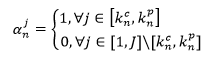
In other words, if the current time index [t] is between arrival and departure time, the binary variable is True. Otherwise, if the current time index [t] is less than arrival time or higher than departure time, is False.
For each EV "n" and for each time index "t", the variable a[n,t] is calculated as a Constraint of the optimization problem:

In [ ]:
#----------Parâmetro binário: status de conexão do VE "n"------------#        
    def alpha(m, n, t):
        if (t >= m.arr.value[n] and m.dep.value[n] >= t for n in m.ev for t in m.time):
            return (m.a[n,t] == True for n in m.ev for t in m.time)
        else:
            return (m.a[n,t] == False for n in m.ev for t in m.time)   
        return Constraint.Skip

#### 1.5. Charging rate constraint:

The charging rate must be constrained by the binary variable that represent the EV connection status:

In [ ]:
#----------------Restrição de taxa de carregamento-------------------#
    def _C(m, n, t):
        return (m.C[n,t] <= m.a[n,t] for n in m.ev for t in m.time)
    # OBS m.C[n,t] is from optimization (charging rate = decision variable)

#### 1.6. EV Power Limitation:
In accordance with each EV characteristic, a maximum charging power constraint must be defined. At aeach timestep "t", the result of multiplication between the charging rate C[n,t] defined in optimization and the maximum acceptable power by the EV "n" defined by data file (data.py) must be equal or less than the maximum power accepted by the vehicle.

In [ ]:
#------------------Limite de potência VE-----------------------------#
    def _Pmax_EV (m, n, t):
        return (m.C[n,t]*m.Pmax[n] <= m.Pmax[n] for n in m.ev for t in m.time)
            # OBS m.C[n,t] is from optimization (charging rate = decision variable)

##### Here comes the first important question: It is possible to use a variable from the Parking Lot Block?
I need to use the decision variable C[n,j] to calculate the power provided for the EV at each timestep. Which mens that the value defined by optimization must be used to satisfy this constraint.

This question also applies for the later use of C[n,j] variable above.

#### 1.6. SoC calculation:
For each EV "n" and at each timestep "t" the SoC must be calculated. This is the most important variable for optimization, since it defines other important variables. 
If the current timestep "t" is equal to the arrival time of EV "n", then the current SoC (SoC[n,t]) is equal to the initial SoC defined in data file (SoCi[n]).
For the later timesteps, the calculation is done according to the equation below:
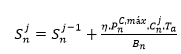
It is considered the SoC of the timestep [t-1] plus the new SoC based on EV characteristics from (data.py):

In [ ]:
#----------------------Cálculo do SoC do VE "n"----------------------#        
    def _SoC(m, n, t):
        if (t == m.arr.value[n] for n in m.ev for t in m.time):
            return (m.SoC[n,t] == m.SoCi[n] for n in m.ev for t in m.time)
        elif m.a[n,t] is True:
            return (m.SoC[n,t] == ((m.SoC[n,t-1] + m.ef*m.Pmax[n]*m.C[n,t]\
                                    *m.Ta))/m.Bcap[n] for n in m.ev for t in m.time)
                # OBS m.C[n,t] is from optimization
        else:
            return Constraint.Skip

#### 1.7. Maximum, minumim and departure SoC:
Maximum and minimum SoC limitations are imposed for each EV "n" at each timestep "t". Another Constraint is related to the desired departure SoC by the user.

In [ ]:
#------------------------SoC máximo----------------------------------#
    def _SoC_max (m, n, t):
        return (m.SoC[n,t] <= 1.0 for n in m.ev for t in m.time)

#------------------------SoC mínimo----------------------------------#
    def _SoC_min (m, n, j):                                           
        return (m.SoC[n,t] >= 0.0 for n in m.ev for t in m.time)

#------------------SoC desejado na partida---------------------------#
    def _SoC_dep (m, n, j):
        if (m.dep.value[n] == t for n in m.ev for t in m.time):
            return (m.SoC[n,t-1] + sum(((m.ef*m.Pmax[n]*m.C[n, t]*m.Ts)\
                /(m.Bcap[n])) for n in m.ev for t in m.time)) >= m.SoCf[n]
                # OBS m.C[n,t] is from optimization

#### 1.8. Degradation Cost:
At each timestep "t" the degradation cost of each EV "n" calculation is performed, since this variable is used to calculate de degradation cost index, which is a coefficient of the objective function. The equation below describes it:
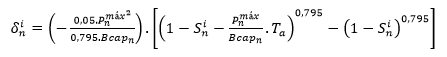
EV characteristics from (data.py) are used, such as maximum power (Pmax), battery capacity (Bcap), SoC and time sample (Ts).

In [ ]:
#--------------Cálculo do custo de degradação do VE "n"--------------#            
    def _Cdeg(m, n, t):
        if (t == m.arr.value[n] for n in m.ev for t in m.time):
            return (m.Cdeg[n,t] == m.Cdegi[n] for n in m.ev for t in m.time)
        elif (m.a[n,t] is True for n in m.ev for t in m.time):
            return m.Cdeg[n,t] == ((-(0.05*(m.Pmax[n]*m.C[n,t])**2)/(0.795\
                                     *m.Bcap[n]))*(((1-m.SoC[n,t]-((m.Pmax[n]/m.Bcap[n])\
                               *m.Ts))**0.795)-((1-m.SoC[n])**0.795)) for n in m.ev for t in m.time)
                    # OBS m.C[n,t] is from optimization
        else:
            return Constraint.Skip

### 2. Optimization indexes:

#### 2.1. Charging Priority index:
The priority index is calculated based on the amaount of energy needed to achive the desired SoC and the time left in the parking lot, as described in the equation below:
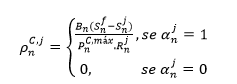
If the binary variable is true (which means that the EV is connected), then the charging priority index for EV "n" at the current timestep "t" is calculated. Otherwise the constraint is skipped.

In [ ]:
#--------------------------------------------------------------------#
#                   Índices para otimização                          #
#--------------------------------------------------------------------#
#------------------Cálculo do índice de preferência------------------#              
    def _roC(m, n, t):
        if (m.a[n,t] is True for n in m.ev for t in m.time):
            return m.roC == ((m.Bcap[n]*(m.SoCf[n]-m.SoC[n,t]))/(m.Pmax[n]*\
                                (m.dep[n]-t)*m.Ts) for n in m.ev for t in m.time)
        else:
            return Constraint.Skip

#### 2.2. Degradation Cost index:
Based on maximum, minimum and current degradation cost of each EV "n", the degradation cost index is calculated as described by the equation below:
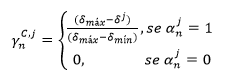

In [ ]:
#------------------Cálculo do índice de degradação------------------#
    def _yC(m, n, t):
        if (m.a[n,t] is True for n in m.ev for t in m.time):
            return m.yC[n,t] == (((m.Cdeg_max[n]-m.Cdeg[n,t])\
                           /(m.Cdeg_max[n]-m.Cdeg_min[n])) for n in m.ev for t in m.time)
        else:
            return Constraint.Skip

In [ ]:
            self.Cdeg_min = Constraint(self.ev,             rule=_Cdeg_min, doc='Minimum degradation cost')
            self.Cdeg_max = Constraint(self.ev,             rule=_Cdeg_max, doc='Maximum degradation cost')
            self.Cdegi    = Constraint(self.ev,             rule=_Cdegi,    doc='Initial degradation cost')
            self.a        = Constraint(self.ev, self.time,  rule=alpha,     doc='Connection status (binary)')
            self.C        = Constraint(self.ev, self.time,  rule=_C,        doc='Charging rate constraint')
            self.Pmax_EV  = Constraint(self.ev, self.time,  rule=_Pmax_EV,  doc='Maximum EV power')
            self.SoC      = Constraint(self.ev, self.time,  rule=_SoC,      doc='State os Charge (SoC)')
            self.SoC_max  = Constraint(self.ev, self.time,  rule=_SoC_max,  doc='Maximum SoC')
            self.SoC_min  = Constraint(self.ev, self.time,  rule=_SoC_min,  doc='Minimum SoC')
            self.SoC_dep  = Constraint(self.ev, self.time,  rule=_SoC_dep,  doc='Departure time SoC')
            self.Cdeg     = Constraint(self.ev, self.time,  rule=_Cdeg,     doc='Degradation cost')
            self.yC       = Constraint(self.ev, self.time,  rule=_yC,       doc='Degradation cost index')
            self.roC      = Constraint(self.ev, self.time,  rule=_roC,      doc='Charging preference index')